# Regularization in Logistic Regression


Here I will explore the regularization in Logistic Regression

The data:

- I use a data that has 5 informative features. 
- 3 columns are collinear with the first informative column.
- 4 random data columns:

In [45]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import matplotlib.pyplot as plt

n_samples = 250

# Create 5 informative columns
X_informative, y_all = make_classification(
    n_samples=n_samples,
    n_classes=2,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    random_state=42,
)

## Create 3 non-informative columns
random_columns = np.random.rand(n_samples, 3)

# ## Create 4 columns of linear combination of existing 5 columns
# weights = np.random.rand(5, 4)
# linear_comb_columns = X_informative @ weights

### Create 3 columns as linear combination of the first informative column
weights_single_feature = np.random.rand(1, 3)  # Shape (1,3)
linear_comb_single_feature = (
    X_informative[:, [0]] @ weights_single_feature
)  # (200,1) @ (1,3) -> (200,3)


X_all = np.hstack([linear_comb_single_feature, X_informative, random_columns])

X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

## Get feature label for index
def f_label(index):
    if index<3:
        return f"C{index}"
    elif index<8:
        return f"X{index-3}"
    else:
        return f"R{index-8}"

## OLS Logistic Regression

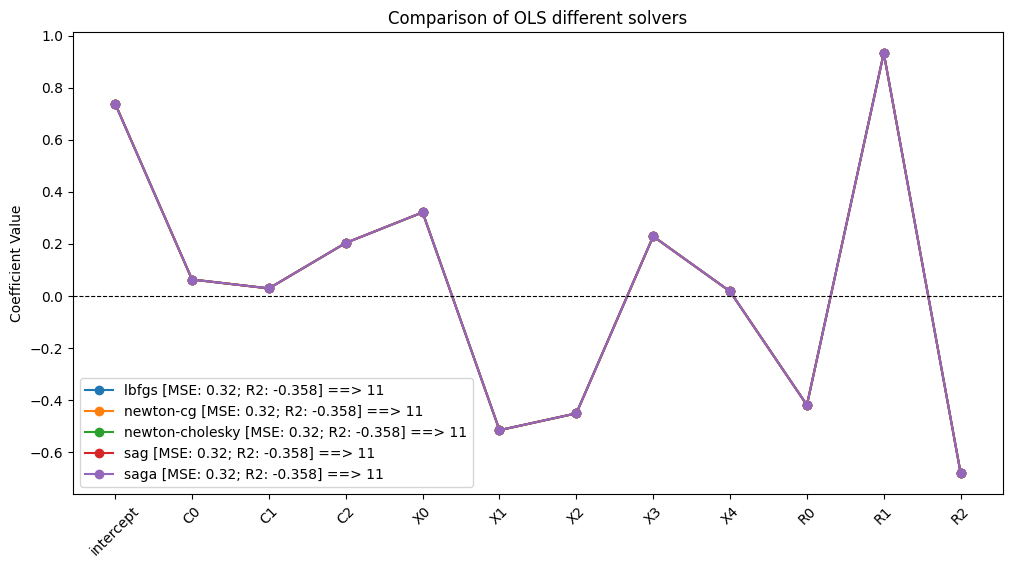

In [46]:
solvers = ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]

ols_coefs = []
ols_perf = []

for solver in solvers:
    clf = LogisticRegression(penalty=None, solver="saga", max_iter=10000)

    clf.fit(X, y)
    ols_coefs += [np.append(clf.intercept_, clf.coef_)]

    y_pred = clf.predict(X_test)
    ols_perf += [[mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]]


plt.figure(figsize=(12, 6))

for i, solver in enumerate(solvers):
    non_zero_coef = sum([x != 0 for x in ols_coefs[i][1:]])
    label = (
        f"{solver} [MSE: {ols_perf[i][0]}; R2: {ols_perf[i][1]:.3}] ==> {non_zero_coef}"
    )
    plt.plot(ols_coefs[i], marker="o", linestyle="-", label=label)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xticks(
    range(X.shape[1] + 1),
    ["intercept"] + [f_label(i) for i in range(X.shape[1])],
    rotation=45,
)
plt.ylabel("Coefficient Value")
plt.title("Comparison of OLS different solvers")
plt.legend()
plt.show()


This is a **BAD** model:

- Coeficient of Determination (R2):
    - `R2 = 1 - MSE / Var(y)`
       - how well the model explains the variance in the data
    - `R2=1`:  model perfectly explains all the variance
    - `R2=0`: model performs as simply predicting mean of the data 
    - `R2<0`: bad model! it's worse than predicting the mean of the data. 

- Also, model is too complex high variability and is fitting the noise! 
  - notice the coefficient for R10 is the largest!


Saga works for L1, L2 and no regularization. I'll continue with `saga` solver.

## L1 Regularization

Lasso is cool for feature selection; Let's evaluate the power of the regularization of Lasso 

Note that in the sklearn LogReg implementation `C` is the reverse regularization. 

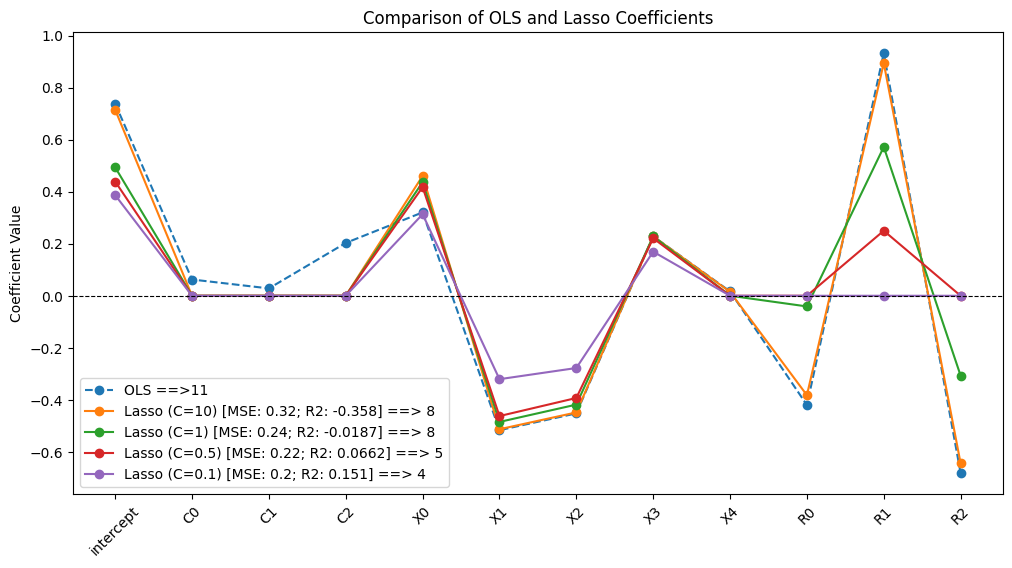

In [47]:
# C values are reverse regularization; smaller value: higher regularization
regularization = [10, 1, 0.5, 0.1]

l1_coefs = []
l1_perf = []

for reg_power in regularization:
    clf = LogisticRegression(
        penalty="l1", C=reg_power, solver="saga", max_iter=10000, random_state=42
    )

    clf.fit(X, y)
    l1_coefs += [np.append(clf.intercept_, clf.coef_)]

    y_pred = clf.predict(X_test)
    l1_perf += [[mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]]


plt.figure(figsize=(12, 6))

plt.plot(
    ols_coefs[-1],
    marker="o",
    linestyle="--",
    label=f"OLS ==>{sum([x!=0 for x in ols_coefs[-1][1:]])}",
)

for i, reg_power in enumerate(regularization):
    non_zero_coef = sum([x != 0 for x in l1_coefs[i][1:]])
    label = f"Lasso (C={reg_power}) [MSE: {l1_perf[i][0]}; R2: {l1_perf[i][1]:.3}] ==> {non_zero_coef}"
    plt.plot(l1_coefs[i], marker="o", linestyle="-", label=label)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xticks(
    range(X.shape[1] + 1),
    ["intercept"] + [f_label(i) for i in range(X.shape[1])],
    rotation=45,
)
plt.ylabel("Coefficient Value")
plt.title("Comparison of OLS and Lasso Coefficients")
plt.legend()
plt.show()

- increase in regularization power (lower C values), yields to fewer features. 
- with all regularization values, collinear features get removed. 
  - interestingly, `X4` which was the basis for C1, C2, and C3 columns will be maintained. 
- with strong regularization (C=.1), random variables will also be removed (as well as X7!!!)


- Mean Squared Error (MSE) reduces with stronger regularization:
    - model makes less error in prediction. 
- Coeficient of Determination (R2) increases.
   - model is getting better in explaining the variance in the data

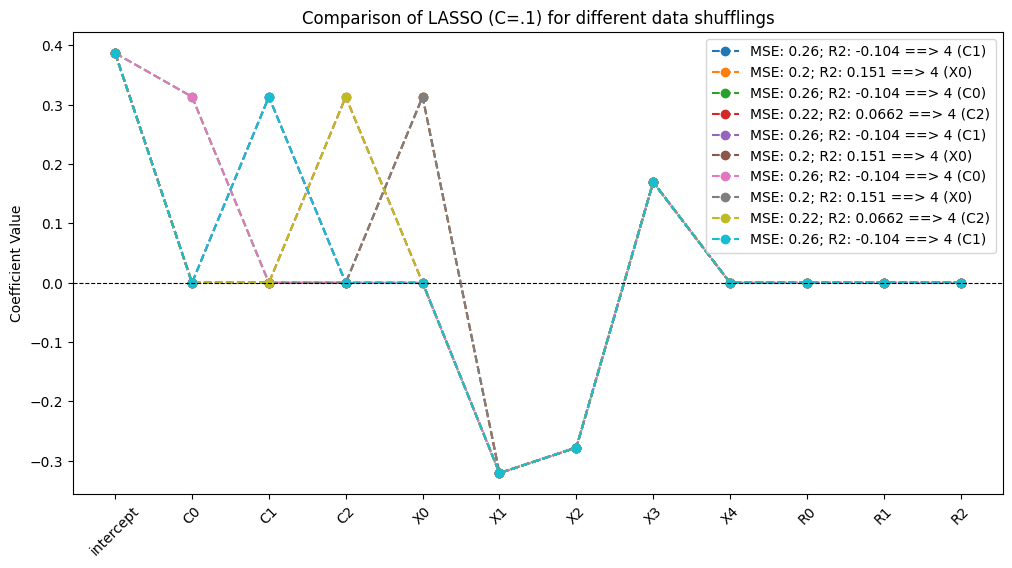

In [48]:
# running Lasso multiple times to see if X4 get removed instead of C1/2/3 ?

l1_coefs = []
l1_perf = []

rand_states = np.random.randint(1, 10000, size=10)


for rnd_state in rand_states:
    clf = LogisticRegression(
        penalty="l1", C=0.1, solver="saga", max_iter=10000, random_state=rnd_state
    )
    shuffled_indices = np.append(
        ## Shuffle the first 4 collumn indices
        np.random.permutation(range(4)),
        # maintain the rest of collum orderings
        range(4, 11),
    )
    X_shuffled = X[:, shuffled_indices]  # Apply

    clf.fit(X_shuffled, y)
    l1_coefs += [np.append(clf.intercept_, clf.coef_)]

    y_pred = clf.predict(X_test)
    l1_perf += [[mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]]

plt.figure(figsize=(12, 6))

# plt.plot(ols_coef, marker='o', linestyle='-', label=f'OLS ==>{sum([x!=0 for x in ols_coef[1:]])}')

for i, rnd_state in enumerate(rand_states):
    non_zero_coef = sum([x != 0 for x in l1_coefs[i][1:]])
    which_x0 = [f_label(i) for i, x in enumerate(l1_coefs[i][1:5]) if x!=0]
    label = f"MSE: {l1_perf[i][0]}; R2: {l1_perf[i][1]:.3} ==> {non_zero_coef} ({which_x0[0]})"
    plt.plot(l1_coefs[i], marker="o", linestyle="--", label=label)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xticks(
    range(X.shape[1] + 1),
    ["intercept"]
    + [f_label(i) for i in range(X.shape[1])],
    rotation=45,
)
plt.ylabel("Coefficient Value")
plt.title("Comparison of LASSO (C=.1) for different data shufflings")
plt.legend()
plt.show()

- Different random seeds and shufflings will maintain different "copies" of the first informative feature. 
- They have very different performances despite the coefficents being the same!

## L2 Regularization


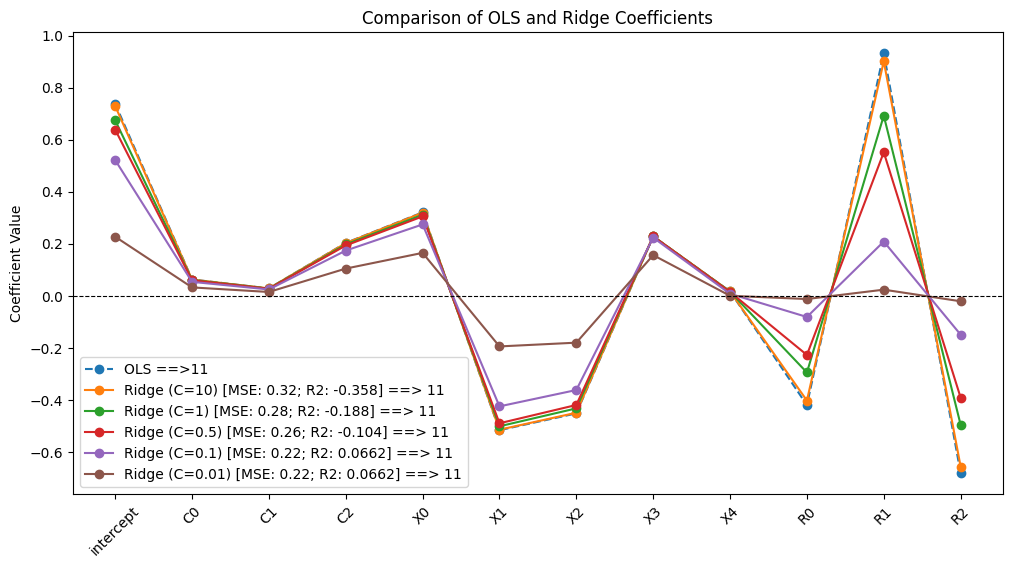

In [50]:
# C values are reverse regularization; smaller value: higher regularization
regularization = [10, 1, 0.5, 0.1, 0.01]

l2_coefs = []
l2_perf = []

for reg_power in regularization:
    clf = LogisticRegression(
        penalty="l2", C=reg_power, solver="saga", max_iter=10000, random_state=42
    )
    clf.fit(X, y)
    l2_coefs += [np.append(clf.intercept_, clf.coef_)]

    y_pred = clf.predict(X_test)
    l2_perf += [[mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)]]


plt.figure(figsize=(12, 6))

plt.plot(
    ols_coefs[-1],
    marker="o",
    linestyle="--",
    label=f"OLS ==>{sum([x!=0 for x in ols_coefs[-1][1:]])}",
)

for i, reg_power in enumerate(regularization):
    non_zero_coef = sum([x != 0 for x in l2_coefs[i][1:]])
    label = f"Ridge (C={reg_power}) [MSE: {l2_perf[i][0]}; R2: {l2_perf[i][1]:.3}] ==> {non_zero_coef}"
    plt.plot(l2_coefs[i], marker="o", linestyle="-", label=label)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.xticks(
    range(X.shape[1] + 1),
    ["intercept"] + [f_label(i) for i in range(X.shape[1])],
    rotation=45,
)
plt.ylabel("Coefficient Value")
plt.title("Comparison of OLS and Ridge Coefficients")
plt.legend()
plt.show()